# Local methods, preprocessing and EDA

**Install and import packages**

In [ ]:
%pip install --upgrade jupyter
%pip install pandas
%pip install cmake
%pip install lightgbm
%pip install darts
%pip install seaborn
%pip install optuna
%pip install matplotlib
%pip install joblib
%pip install seaborn
%pip install tqdm
%pip install torch
%pip install sklearn
%pip install scikit-learn
%pip install pandas_profiling

In [2]:
#Imports

# multiprocessing
from joblib import Parallel, delayed

# data manipulation
import numpy as np
import pandas as pd
import heapq

# data visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm

#hmm needed? 
import torch
import torch.nn as nn
#from torch import nn
import torch.optim as optim
import shutil
import sklearn
from sklearn.preprocessing import MinMaxScaler
#from tqdm import tqdm_notebook as tqdm

#darts
# transformers and preprocessing
import darts
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.utils.utils import SeasonalityMode, TrendMode, ModelMode
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.models import * #everything

#loss metrics
from darts.metrics import mape
from darts.metrics import smape
from darts.utils.losses import SmapeLoss

# likelihood
from darts.utils.likelihood_models import GaussianLikelihood

# settings
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

#hyperparameter tuning
import optuna
from optuna.integration import PyTorchLightningPruningCallback
from optuna.visualization import (
    plot_optimization_history,
    plot_contour,
    plot_param_importances,
)
from pytorch_lightning.callbacks import Callback, EarlyStopping
from sklearn.preprocessing import MaxAbsScaler

#extras
import os
import time
import random
from datetime import datetime
from itertools import product
from typing import List, Tuple, Dict
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import Ridge
import statistics


# Load and inspect data

**Define loading and preprocessing function**

In [3]:
def load_preprocess(csv_file):

    ''' Loading and preprocessing data from csv. Return list of time-series IDs and preprocessed csv.'''

    #Read data
    raw_data = pd.read_csv(csv_file)

    #Cut off before 1950
    raw_data = raw_data[raw_data['Year'] >= 1950]

    #Transform timestamp to datetime format
    raw_data['Year'] = pd.to_datetime(raw_data['Year'], format='%Y')

    #Drop "Code" column
    raw_data = raw_data.drop(['Code'], axis=1)

    #Rename columns
    raw_data = raw_data.rename(columns={"Life expectancy at birth (historical)":"LE", "Entity":"Country"})

    #Exclude entries that are not countries/territories
    exclude = ['Africa', 'Asia','Americas', 'Europe', 'High-income countries', 'More developed regions','Land-locked Developing Countries (LLDC)', 'Latin America and the Caribbean','Least developed countries','Less developed regions','Less developed regions, excluding China','Less developed regions, excluding least developed countries', 'Low-income countries','Lower-middle-income countries','More developed regions','Northern America','Oceania','Small Island Developing States (SIDS)','Upper-middle-income countries','World']

    # Subset the DataFrame based on the countries/territories of interest
    data_countries = raw_data.loc[~raw_data['Country'].isin(exclude)]

    #create list of countries for later
    countries = list(data_countries["Country"].unique())

    #Write to csv
    data_countries.to_csv('life_expectancy_data.csv', index=False)

    #Get dataframe for further work
    data_pd = pd.DataFrame(data_countries)

    return countries, data_pd

# Exploratory analysis

We leverage Pandas Profiling Report to get an idea of our data structure. It includes various statistics.

To check autocorrelation, we need to this for each time series individually. 


In [4]:
countries, data_pd = load_preprocess('life-expectancy.csv')

In [5]:
from pandas_profiling import ProfileReport

profile = ProfileReport(data_pd, tsmode=True, sortby="Year")
profile.to_file('profile_report.html')
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

**Autocorrelation**

In [6]:
#Pivot DataFrame
data_wide = data_pd.pivot(index='Year', columns='Country', values='LE')

#Calculate autocorrelation
autocorr_results = data_wide.apply(lambda x: x.autocorr()) #series

#Extract the mean, sd and median
print(autocorr_results.mean())
print(autocorr_results.std())
print(autocorr_results.median())

0.9874793805916966
0.028249862885003686
0.9969719707409795


**Visualize a subset of countries**

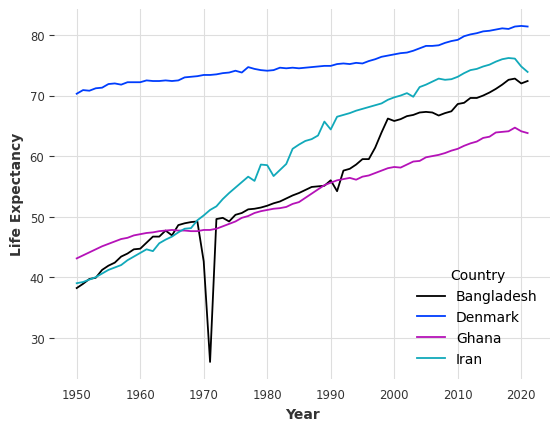

In [7]:
#Let's look at just a few countries
countries_of_interest = ['Denmark', 'Bangladesh', 'Iran','Ghana']
subset_df = data_pd.loc[data_pd['Country'].isin(countries_of_interest)]

#Plot
sns.lineplot(x="Year", y="LE",
             hue="Country",
             data=subset_df)

plt.xlabel("Year")
plt.ylabel("Life Expectancy")
plt.legend(title="Country")
plt.show()

# Local methods

**Splits**

NB: These splits are chosen to accommodate comparison with the Transformer, where we need to split in validation as well. 
Therefore, the training split it slightly larger than the usual 80%.

Training: 62 years (1950-2011) = 86 %. 

Testing: 10 years (2012-2021) = 14 %. 

Forecasting horizon: 10 years. 



**Defining functions**

In [8]:
def transform_split(dataframe: pd.DataFrame) -> Tuple[List[TimeSeries], List[TimeSeries]]:
    ''' Transform DataFrame to TimeSeries object.
    Split in train and test. Return full TimeSeries object, train TimeSeries object, and test TimeSeries object. '''
    
    #To timeseries
    dataset_ts = TimeSeries.from_group_dataframe(df=dataframe, 
                                             group_cols=['Country'],
                                             time_col='Year', 
                                             value_cols='LE')
    # Split train/test
    print("splitting train/test...")
    train: List[TimeSeries] = [s[:-HORIZON] for s in dataset_ts]
    test: List[TimeSeries] = [s[-HORIZON:] for s in dataset_ts]

    print("There are in total {} series".format(len(train))),
    print("Years applied for training: {}".format(np.mean([len(s) for s in train])),
    print("Years applied for testing (forecasting horizon): {}".format(np.mean([len(s) for s in test]))
        )
    )
    return dataset_ts, train, test


def eval_forecasts(
    name,
    pred_series: List[TimeSeries], 
    test_or_val_series: List[TimeSeries],
) -> List[float]:
    ''' Computing sMAPEs between predictions and ground truth (test data). 
    Plotting the distribution and retrieving the median sMAPE. '''
    print("computing sMAPEs...")
    smapes = smape(test_or_val_series, pred_series)
    plt.figure(figsize=(8,6))
    #plt.hist(smapes, bins=50)
    sns.histplot(smapes,kde=True, color='blue')
    plt.ylabel("Count")
    plt.xlabel("sMAPE")
    plt.title("Model: {}".format(name))
    subtitle = "Median sMAPE: {:.3f} and mean sMAPE: {:.2f} +- {:.2f}".format(np.median(smapes), np.mean(smapes), np.std(smapes))
    plt.text(0.5, 0.92, subtitle, ha='center', va='center', transform=plt.gca().transAxes, fontsize=10)
    plt.show()
    plt.close()
    return smapes

def eval_local_model(
    ID_list: List[str],
    train_series: List[TimeSeries], 
    test_series: List[TimeSeries], 
    model_cls, 
    **kwargs
) -> Tuple[List[float], float, List[Tuple[str, float]]]:

    ''' Fitting the model of choice to training data. Retrieving predictions for a given forecasting horizon.
    Extracting computation time. Extracting sMAPEs per time-series and the time-series with highest sMAPEs. '''

    #define empty lists for predictions and processing time
    preds = []
    start_time = time.time()

    #Fit model and predict for each series individually
    print("fitting models...")
    for series in tqdm(train_series):
        model = model_cls(**kwargs)
        model.fit(series)
        pred = model.predict(n=HORIZON)
        preds.append(pred)
    elapsed_time = time.time() - start_time

    name = model.__class__.__name__

    #Apply eval_forecasts function to extract sMAPEs and plot
    print("extracting sMAPEs...")
    smapes = eval_forecasts(name, preds, test_series)

    #Extract sMAPES per time-series and time-series with highest sMAPEs
    smapes_pr_country = list(zip(countries, smapes))
    highest_smapes = heapq.nlargest(10, smapes_pr_country, key=lambda x: x[1])
    lowest_smapes = heapq.nsmallest(10, smapes_pr_country, key=lambda x: x[1])
    
    return smapes, elapsed_time, smapes_pr_country, highest_smapes, lowest_smapes, preds

def sMAPE_stats(smapes_pr_country, threshold = int):

    ''' Extract central statistics related to sMAPEs'''
    
    threshold = threshold
    _above = [item for item in smapes_pr_country if item[1] > threshold]
    _below = [item for item in smapes_pr_country if item[1] <= threshold]
    _above_values = [item[1] for item in _above]
    _below_values = [item[1] for item in _below]
    print("There are {} series with an sMAPE above {}".format(len(_above), threshold))
    print("There are {} series with an sMAPE of or beneath {}".format(len(_below), threshold))
    print("Statistics for highest sMAPEs:")
    print("The mean error for series with an sMAPE above {} is {}".format(threshold, statistics.mean(_above_values)))
    print("The sd for series with an sMAPE above {} is {}".format(threshold, statistics.stdev(_above_values)))
    print("The median error for series with an sMAPE above {} is {}".format(threshold, statistics.median(_above_values)))
    print("Statistics for lowest sMAPEs:")
    print("The mean error for series with an sMAPE of or below {} is {}".format(threshold, statistics.mean(_below_values)))
    print("The sd for series with an sMAPE of or below {} is {}".format(threshold, statistics.stdev(_below_values)))
    print("The median error for series with an sMAPE of or below {} is {}".format(threshold, statistics.median(_below_values)))

**Split and transform data format**

In [9]:
#Define forecasting horizon
HORIZON = 10

#Transform and split data
data, train, test = transform_split(data_pd)

splitting train/test...
There are in total 237 series
Years applied for testing (forecasting horizon): 10.0
Years applied for training: 62.0 None


**Naive Drift**

fitting models...


100%|██████████| 237/237 [00:00<00:00, 531.09it/s]


extracting sMAPEs...
computing sMAPEs...


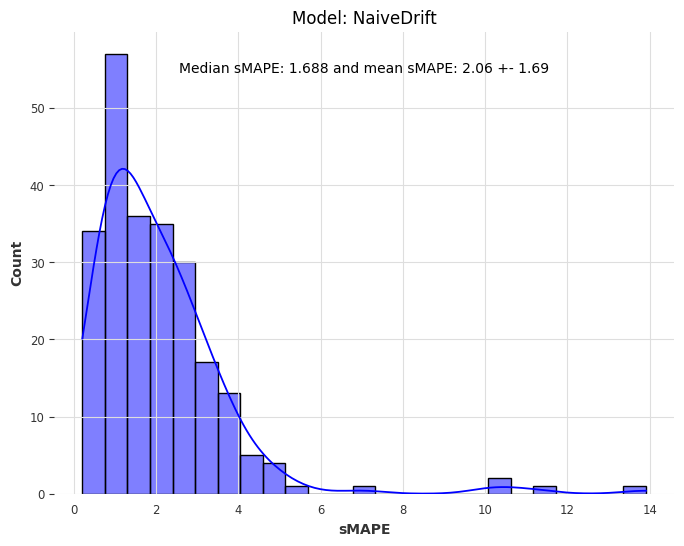

In [10]:
naive_smapes, naive_time, naive_smapes_pr_country, naive_highest_smapes, naive_lowest_smapes, naive_preds = eval_local_model(countries, train, test, NaiveDrift)

In [11]:
#Print list of 10 countries with highest sMAPEs
print(naive_highest_smapes)

#How many sMAPEs above 5?
sMAPE_stats(naive_smapes_pr_country, threshold=5)

[('Eswatini', 13.911730785413646), ('Syria', 11.192632210736859), ('Zimbabwe', 10.425183250420115), ('Lesotho', 10.086673287589845), ('Yemen', 6.9899656439462134), ('Somalia', 5.528986492563007), ('Oman', 5.031317420648938), ('Namibia', 4.840160791854798), ('Mexico', 4.7340682590118774), ('Mayotte', 4.69834367347323)]
There are 7 series with an sMAPE above 5
There are 230 series with an sMAPE of or beneath 5
Statistics for highest sMAPEs:
The mean error for series with an sMAPE above 5 is 9.02378415590266
The sd for series with an sMAPE above 5 is 3.2654605582686065
The median error for series with an sMAPE above 5 is 10.086673287589845
Statistics for lowest sMAPEs:
The mean error for series with an sMAPE of or below 5 is 1.8524753443223865
The sd for series with an sMAPE of or below 5 is 1.0731421053629016
The median error for series with an sMAPE of or below 5 is 1.647326251010346


**Holts Exponential Smoothing**

fitting models...


100%|██████████| 237/237 [00:03<00:00, 64.38it/s]


extracting sMAPEs...
computing sMAPEs...


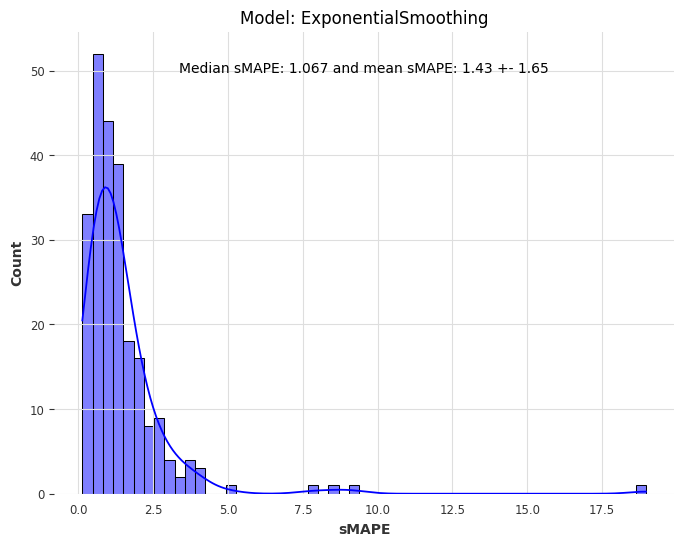

In [12]:
ses_smapes, ses_time, ses_smapes_pr_country, ses_highest_smapes, ses_lowest_smapes, ses_preds = eval_local_model(countries, train, test, ExponentialSmoothing, seasonal = None, seasonal_periods = None, damped = True)

In [13]:
#Print list of 10 countries with highest sMAPEs
print(ses_highest_smapes)

#How many sMAPEs above 5?
sMAPE_stats(ses_smapes_pr_country, threshold = 5)

[('Libya', 18.968496158102752), ('Syria', 9.213310051622924), ('South Africa', 8.620712030941876), ('Somalia', 7.792663752047992), ('Oman', 4.98597098884094), ('Yemen', 4.202204627363735), ('Namibia', 4.130595726708767), ('Myanmar', 3.9950530808560667), ('Jamaica', 3.776882505524633), ('Burundi', 3.666981067188341)]
There are 4 series with an sMAPE above 5
There are 233 series with an sMAPE of or beneath 5
Statistics for highest sMAPEs:
The mean error for series with an sMAPE above 5 is 11.148795498178886
The sd for series with an sMAPE above 5 is 5.245590168238091
The median error for series with an sMAPE above 5 is 8.9170110412824
Statistics for lowest sMAPEs:
The mean error for series with an sMAPE of or below 5 is 1.2679179051564349
The sd for series with an sMAPE of or below 5 is 0.8777332347206411
The median error for series with an sMAPE of or below 5 is 1.0425134794321695


**ARIMA**

fitting models...


100%|██████████| 237/237 [00:05<00:00, 45.35it/s]


extracting sMAPEs...
computing sMAPEs...


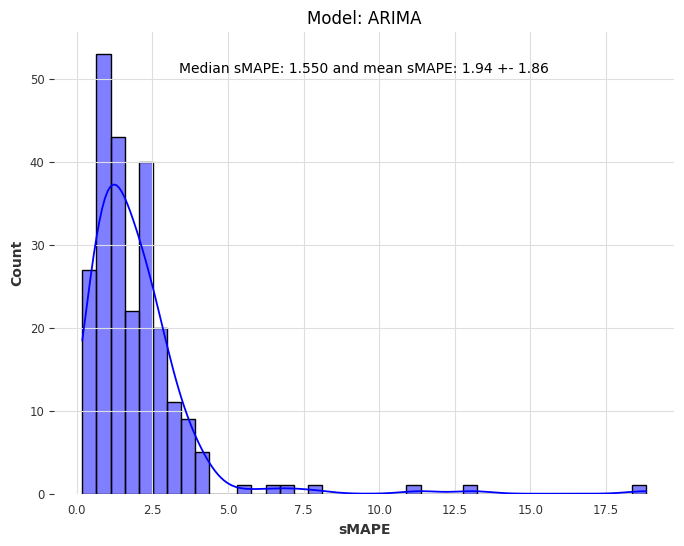

In [14]:
arima_smapes, arima_time, arima_smapes_pr_country, arima_highest_smapes, arima_lowest_smapes, arima_preds = eval_local_model(countries, train, test, ARIMA, p=1, d=1, q=0, trend = 't')

In [15]:
#Print list of 10 countries with highest sMAPEs
print(arima_highest_smapes)

#How many sMAPEs above 5?
sMAPE_stats(arima_smapes_pr_country, threshold=5)

[('Libya', 18.82376020469806), ('Haiti', 13.096952082114255), ('Syria', 11.352249176916725), ('South Africa', 7.83351325791612), ('Yemen', 7.019293828252346), ('Zimbabwe', 6.458400394126842), ('Somalia', 5.561306269713897), ('Eswatini', 4.317020137614832), ('North Korea', 4.315459731256363), ('Saint Vincent and the Grenadines', 4.2688200242951675)]
There are 7 series with an sMAPE above 5
There are 230 series with an sMAPE of or beneath 5
Statistics for highest sMAPEs:
The mean error for series with an sMAPE above 5 is 10.020782173391177
The sd for series with an sMAPE above 5 is 4.745148659065783
The median error for series with an sMAPE above 5 is 7.83351325791612
Statistics for lowest sMAPEs:
The mean error for series with an sMAPE of or below 5 is 1.698766804352777
The sd for series with an sMAPE of or below 5 is 0.9635305676901471
The median error for series with an sMAPE of or below 5 is 1.508396942588952


**Plot som time-series with the high sMAPEs**

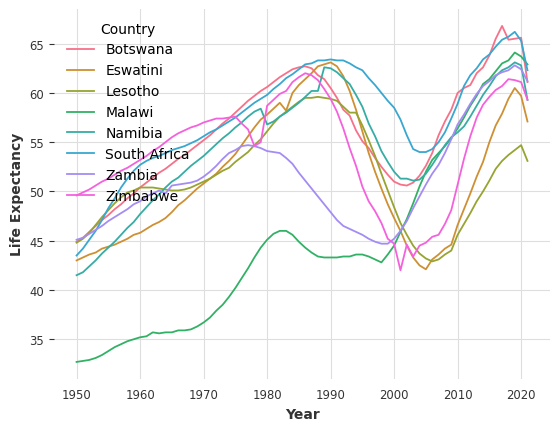

In [34]:
#Define some countries of interest
dip_00 = data_pd.loc[data_pd['Country'].isin(['Lesotho','Zimbabwe','Eswatini', 'South Africa','Namibia', 'Botswana','Malawi','Zambia'])]

#Plot
sns.lineplot(x="Year", y="LE",
             hue="Country",
             data=dip_00)

plt.xlabel("Year")
plt.ylabel("Life Expectancy")
plt.legend(title="Country", loc = "upper left")
plt.show()